In [2]:
import time
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from pyod.models.knn import KNN

# Read Data

In [3]:
nyc_taxis = pd.read_csv('nyc_taxis.csv', delimiter=',', header=0, index_col=0)
nyc_taxis.head(10)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255


**Information**

In [4]:
nyc_taxis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   dropoff_datetime    1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 122.4+ MB


# 1.2 Feature generation

## Create Trip distance column

In [5]:
def haversine_dist(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    
    :params lon1: First point longitude in degrees
    :params lat1: First point latitude in degrees
    :params lon2: Second point longitude in degress
    :params lat2: Second point latitude in degrees
    
    :returns distance in kilometers
    """
    # Convert decimal degrees to radians 
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth(km)
    
    distance = c*r
    
    return np.round(distance,decimals=3)

In [6]:
nyc_taxis['trip_distance(km)'] = haversine_dist(nyc_taxis['pickup_longitude'], nyc_taxis['pickup_latitude'], 
              nyc_taxis['dropoff_longitude'], nyc_taxis['dropoff_latitude'])
nyc_taxis.head(10)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km)
id,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189
id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,1.099
id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,1.326
id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,5.715
id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,1.310


## Create Average speed column

In [7]:
nyc_taxis['avg_speed(km/hr)'] = nyc_taxis['trip_distance(km)']/(nyc_taxis['trip_duration'].apply(lambda x: x/3600))
nyc_taxis.head(10)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km),avg_speed(km/hr)
id,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499,11.860220
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806,9.806335
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385,10.822034
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485,12.461538
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189,9.840000
id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,1.099,8.930926
id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,1.326,13.998827
id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,5.715,13.264990
id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,1.310,18.494118


# Create date columns

In [8]:
# Year
nyc_taxis['trip_year'] = pd.to_datetime(nyc_taxis['pickup_datetime']).dt.year

# Month
nyc_taxis['trip_month'] = pd.to_datetime(nyc_taxis['pickup_datetime']).dt.month

In [9]:
nyc_taxis.head(10)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km),avg_speed(km/hr),trip_year,trip_month
id,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499,11.860220,2016,3
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806,9.806335,2016,6
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385,10.822034,2016,1
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485,12.461538,2016,4
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189,9.840000,2016,3
id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,1.099,8.930926,2016,1
id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,1.326,13.998827,2016,6
id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551,5.715,13.264990,2016,5
id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255,1.310,18.494118,2016,5


# 1.1 Data Cleaning

## Plot box plots

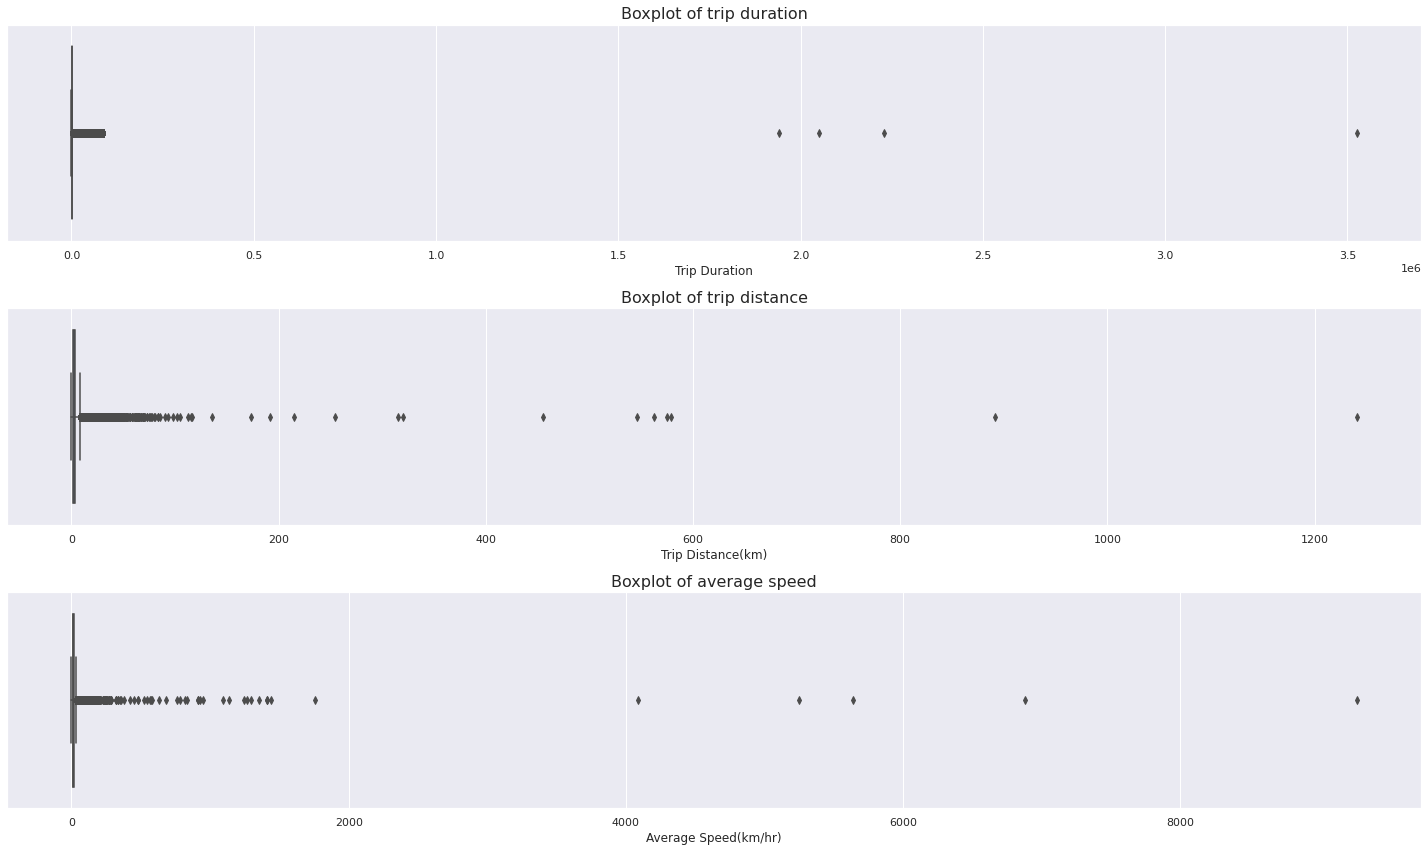

In [10]:
# Plots
fig, axes = plt.subplots(figsize=(20,12),nrows=3, ncols = 1)

sns.boxplot(x=nyc_taxis['trip_duration'], ax=axes[0])
axes[0].set_title('Boxplot of trip duration',fontsize=16)
axes[0].set_xlabel('Trip Duration')

sns.boxplot(x=nyc_taxis['trip_distance(km)'], ax=axes[1])
axes[1].set_title('Boxplot of trip distance',fontsize=16)
axes[1].set_xlabel('Trip Distance(km)')

sns.boxplot(x=nyc_taxis['avg_speed(km/hr)'], ax=axes[2])
axes[2].set_title('Boxplot of average speed',fontsize=16)
axes[2].set_xlabel('Average Speed(km/hr)')

plt.tight_layout()
plt.show()

**Inital observations:**

* From the plots above we can see that there clearly some outliers in the dataset.
* The trip duration plot: It looks like the outliers occur from around $2.0\times 10^{6}$seconds. This is roughly equal to 555 hours. This is not really possible.
* The trip distance plot: Some of the values from above 200km could be outliers but we can investigate further.
* The average speed plot could have values influenced by the outliers in the trip duration or trip distance.

## 1. Investigate trip duration

**Z-score**

In [11]:
z_score_1 = np.abs(stats.zscore(nyc_taxis['trip_duration']))
thresh = 3

# position of the outlier
outlier_idx = np.where(z_score_1>thresh)
print('Outliers found',len(outlier_idx[0]))

Outliers found 2073


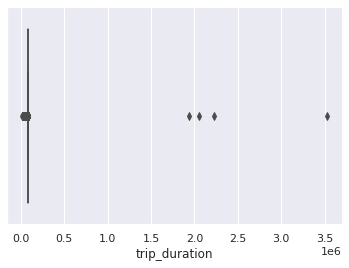

In [12]:
# View outliers
nyc_taxis.iloc[outlier_idx[0]]
sns.boxplot(x=nyc_taxis.iloc[outlier_idx[0]]['trip_duration'])
plt.show()

Here we can see that my inital assumption about some of the larger outliers was correct. What my inital observation missed was some the lower outliers that could occur.

In [13]:
# Drop the rows
# nyc_taxis.drop( nyc_taxis.iloc[outlier_idx].index,axis=0, inplace=True)

In [14]:
# Result after
# sns.boxplot(x=nyc_taxis['trip_duration'])
# plt.show()

**Manually**

## 2. Investigate trip distance

**Z-score**

In [15]:
z_score_2 = np.abs(stats.zscore(nyc_taxis['trip_distance(km)']))
thresh = 3

# position of the outlier
outlier_idx_2 = np.where(z_score_2>thresh)
print('Outliers found',len(outlier_idx_2[0]))

Outliers found 40117


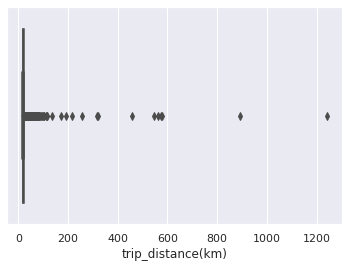

In [16]:
# View outliers
nyc_taxis.iloc[outlier_idx_2[0]]
sns.boxplot(x=nyc_taxis.iloc[outlier_idx_2[0]]['trip_distance(km)'])
plt.show()

We can see from the outliers above that my initial observation about the values from 200km was correct and that I may have also missed some values that are below 200km.

In [17]:
# Drop the rows
# nyc_taxis.drop( nyc_taxis.iloc[outlier_idx_2].index,axis=0, inplace=True)

In [18]:
# Result after
# sns.boxplot(x=nyc_taxis['trip_distance(km)'])
# plt.show()

**Manually**

In [20]:
outliers2 = nyc_taxis.iloc[np.where(nyc_taxis['trip_distance(km)']>200)[0]]
outliers2

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km),avg_speed(km/hr),trip_year,trip_month
id,,,,,,,,,,,,,,
id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,N,792,1240.909,5640.495455,2016,5
id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354332,34.712234,-73.834923,32.181141,N,875,314.764,1295.029029,2016,2
id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,N,282,320.126,4086.714894,2016,4
id0982904,1,2016-04-28 13:32:14,2016-04-28 14:14:09,2,-73.870682,40.773598,-79.817978,38.963852,N,2515,545.853,781.340278,2016,4
id0401529,2,2016-06-02 15:19:35,2016-06-02 15:32:59,1,-73.980751,40.757111,-74.240051,38.478298,N,804,254.364,1138.943284,2016,6
id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989914,40.756634,-70.346077,36.398121,N,303,578.843,6877.342574,2016,2
id1001696,1,2016-02-24 21:02:32,2016-02-24 21:25:57,1,-73.972366,40.758633,-79.553535,43.674000,N,1405,562.235,1440.602135,2016,2
id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,N,611,891.214,5251.015385,2016,1
id3626673,1,2016-05-05 18:02:50,2016-05-05 18:18:23,1,-73.978912,40.756763,-79.338699,41.427902,N,933,455.241,1756.556913,2016,5


We can see that for trip distances above 200km the drivers woud need to be travelling above 600km/hr to cover the trip distances in the stipulated trip durations. These are outliers and can be removed.

In [21]:
# Drop rows
# nyc_taxis.drop( outliers2.index,axis=0,inplace=True)

In [22]:
# plot of trip duration
# sns.boxplot(x=nyc_taxis['trip_distance(km)'])
# plt.show()

## 3. Investigate average speed

**Z-score**

In [23]:
z_score_3 = np.abs(stats.zscore(nyc_taxis['avg_speed(km/hr)']))
thresh = 3

# position of the outlier
outlier_idx_3 = np.where(z_score_3>thresh)
print('Outliers found',len(outlier_idx_3[0]))

Outliers found 734


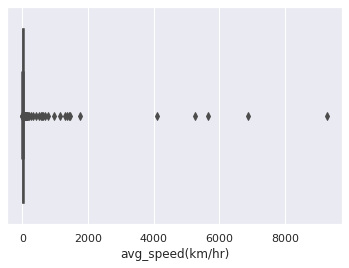

In [24]:
# View outliers
nyc_taxis.iloc[outlier_idx_3[0]]
sns.boxplot(x=nyc_taxis.iloc[outlier_idx_2[0]]['avg_speed(km/hr)'])
plt.show()

Here we can see that some of the avg speed above 2000km/hr are outliers and can be removed from the dataset.

In [25]:
# Drop the rows
# nyc_taxis.drop( nyc_taxis.iloc[outlier_idx_3].index,axis=0, inplace=True)

In [26]:
# Result after
# sns.boxplot(x=nyc_taxis['avg_speed(km/hr)'])
# plt.show()

**Manually**

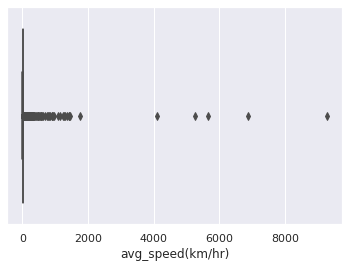

In [27]:
sns.boxplot(x=nyc_taxis['avg_speed(km/hr)'])
plt.show()

From this we can see that there is an outlier that we can investigate

In [29]:
outliers3 = nyc_taxis.iloc[np.where(nyc_taxis['avg_speed(km/hr)']>8000)[0]]
outliers3

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km),avg_speed(km/hr),trip_year,trip_month
id,,,,,,,,,,,,,,
id3619353,2,2016-02-13 20:28:30,2016-02-13 20:28:37,1,-73.936974,40.76461,-73.789848,40.646858,N,7,18.034,9274.628571,2016,2


We can assume that an average speed of over 9000km/hr is not possible and so remove this outlier

In [30]:
# Drop rows
# nyc_taxis.drop( outliers3.index,axis=0,inplace=True)

In [31]:
# plot
# sns.boxplot(x=nyc_taxis['avg_speed(km/hr)'])
# plt.show()